In [1]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.gaussian_process import kernels, GaussianProcessRegressor
import pandas as pd
import time
if os.getcwd() == '/Users/cd8607/Documents/Fitting_Potential':
    pass
else:
    os.chdir('../')

In [2]:
whe = np.loadtxt('Potentials/W-He-Juslin.table',skiprows=6)[:,1:3]

In [3]:
def ZBL(rij, Zi, Zj):
    
    e0 = 55.26349406e-4

    const = 1/(4*np.pi*e0)

    a = 0.46850/(Zi**0.23 + Zj**0.23)	

    x = rij/a

    x = x[:, np.newaxis]

    amplitude = np.array([0.18175, 0.50986, 0.28022, 0.02817])
    exponent = np.array([3.19980, 0.94229, 0.40290, 0.20162])

    phi = np.sum(amplitude * np.exp(-exponent * x), axis=1)
         
    return const*phi*(Zi*Zj/rij)

def ZBL_approx(rij, Zi, Zj):
    
    e0 = 55.26349406e-4

    const = 1/(4*np.pi*e0)

    a = 0.46850/(Zi**0.23 + Zj**0.23)	

    x = rij/a

    amplitude = np.array([0.18175, 0.50986, 0.28022, 0.02817])
    exponent = np.array([3.19980, 0.94229, 0.40290, 0.20162])


    phi = np.sum(amplitude) - np.sum(amplitude*exponent)*x
    
    print(np.sum(amplitude*exponent))
    
    return const*phi*(Zi*Zj/rij)

In [4]:
class BayesOpt_PairPot():
        
    def __init__(self, n_params, Zi, Zj):

        self.n_params = n_params

        self.Zi = Zi
        self.Zj = Zj

        self.sample_params()

        self.zbl_amplitude = np.array([0.18175, 0.50986, 0.28022, 0.02817])
        self.zbl_exponent =  np.array([3.19980, 0.94229, 0.40290, 0.20162])
    
    def sample_params(self):

        self.amplitude = np.random.normal(loc = 0, scale = 4, size = (self.n_params,))
        self.mean  = np.linspace(0,1,self.n_params)
        self.sigma = 0.3*np.ones((self.n_params,))

        self.params = np.hstack([self.amplitude, self.mean, self.sigma])

    def set_params(self, params):

        self.amplitude = params[:self.n_params]
        self.mean = params[self.n_params:2*self.n_params]
        self.sigma = params[2*self.n_params:]


    def eval(self, rij):
            
        e0 = 55.26349406e-4

        const = 1/(4*np.pi*e0)

        a = 0.46850/(self.Zi**0.23 + self.Zj**0.23)	
        
        x = rij/a

        x = x[:,np.newaxis]

        phi = np.sum( self.zbl_amplitude* np.exp(-self.zbl_exponent * x), axis=1 )

        return const*phi*(self.Zi*self.Zj/rij) + np.sum( (self.amplitude/(rij[:,np.newaxis]*self.sigma*np.sqrt(2*np.pi)))*np.exp(-(np.log(rij[:,np.newaxis])-self.mean)**2/(2*self.sigma**2)) , axis=1 )


    def loss(self, x, y):

        fx = self.eval(x)

        return np.sum( ((y-fx)**2) )/len(x)
    
    def get_nsamples(self, n, rij, y):

        sampled_loss = np.zeros((n,))
        sampled_params = np.zeros((n, len(self.params)))

        for i in range(n):
            
            self.sample_params()
            sampled_loss[i]   = self.loss(rij, y)
            sampled_params[i] = self.params

        return sampled_loss, sampled_params

In [5]:
Zi = 74
Zj = 2

rand = np.random.randint(low = 0, high = len(whe), size=(5,))

rij = whe[rand,0]

# zbl = ZBL(rij, Zi, Zj)
zbl = whe[rand,1]

opt = BayesOpt_PairPot(4, Zi, Zj)

sampled_loss, sampled_params = opt.get_nsamples(1000, rij, zbl)


0.14886530755177646
(array([ 1.57176879, -0.72591828,  0.36586346, -0.22744101]), array([0.        , 0.33333333, 0.66666667, 1.        ]), array([0.3, 0.3, 0.3, 0.3]))


/var/folders/s9/zg8t26bx2xg094_h3_f559v40000gp/T/ipykernel_66694/689390228.py:15: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(whe[:,0]), np.log(whe[:,1]))


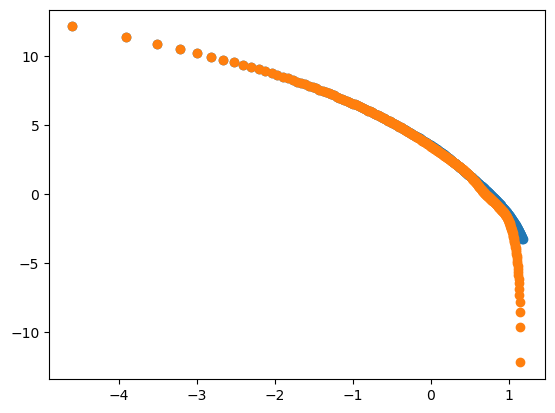

In [6]:
print(sampled_loss.min())

min_params = sampled_params[sampled_loss.argmin()]

opt.set_params(min_params)

# rij = np.logspace(1,-7,100)

# zbl = ZBL(rij, 1, 2)


plty = opt.eval(whe[:,0])

plt.scatter(np.log(whe[:,0]), np.log(np.abs(plty)))
plt.scatter(np.log(whe[:,0]), np.log(whe[:,1]))

print((opt.amplitude, opt.mean, opt.sigma))

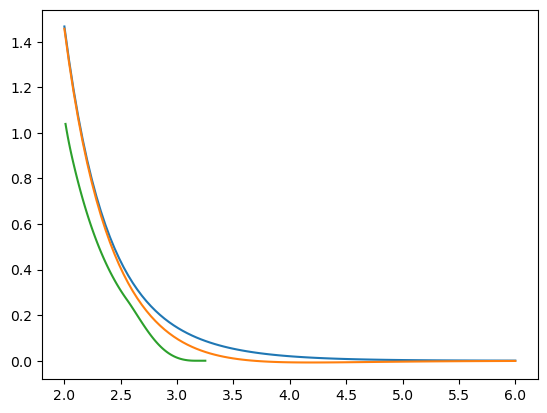

In [7]:
rij = np.linspace(2, 6, 100)

plt.plot(rij, ZBL(rij, 74, 2))
plt.plot(rij, opt.eval(rij))
plt.plot(whe[200:,0], whe[200:,1] )

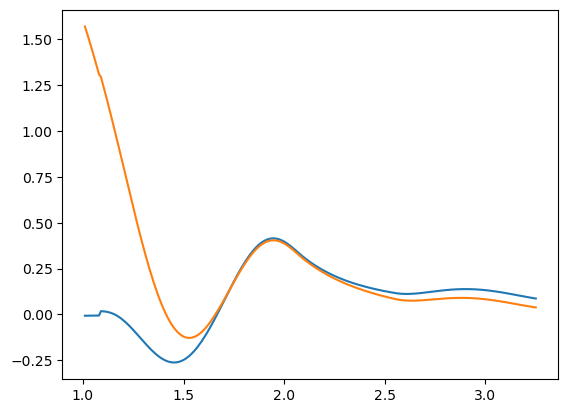

In [8]:
# plt.plot(whe[100:,0], whe[100:,1])
plt.plot(whe[100:,0], ZBL(whe[100:,0], 74, 2) - whe[100:,1] )
plt.plot(whe[100:,0], opt.eval(whe[100:,0]) - whe[100:,1] )

In [9]:
import json 

with open('refs_formations.json', 'r') as ref_file:
    ref_json = json.load(ref_file)

with open('my_formations.json', 'r') as my_file:
    my_json = json.load(my_file)

formation = np.zeros((10,))
relaxation = np.zeros((10,))
positions = []

idx = 0
for n_vac in range(2):
    for n_he in range(1,6):
        formation[idx] = ref_json['V%dH0He%d' % (n_vac,n_he)]['dft']['val'][0]
        relaxation[idx] = ref_json['V%dH0He%d' % (n_vac,n_he)]['r_vol_dft']['val'][0]
        positions.append(my_json['V%dH0He%d' % (n_vac,n_he)]['xyz_opt'])
        idx += 1




In [13]:
with open('refs_formations.json', 'r') as ref_file:
    ref_json = json.load(ref_file)

with open('my_formations.json', 'r') as my_file:
    my_json = json.load(my_file)

N_Vac = 1
N_H = 1
N_He = 3

def data_dict(ref_json, my_json, N_Vac, N_H, N_He):

    ref_dict = {}

    for n_h in range(N_H+1):
        for n_vac in range(N_Vac+1):
            for n_he in range(N_He+1):
                    
                    if n_h + n_vac + n_he > 0 :
                        
                        key = 'V%dH%dHe%d' % (n_vac, n_h, n_he)

                        ref_dict[key] = {}

                        ref_dict[key]['val'] = ref_json['V%dH%dHe%d' % (n_vac, n_h, n_he)]['dft']['val'][0]

                        if len(ref_json['V%dH%dHe%d' % (n_vac, n_h, n_he)]['r_vol_dft']['val']) > 0:
                            ref_dict[key]['rvol'] = ref_json['V%dH%dHe%d' % (n_vac, n_h, n_he)]['r_vol_dft']['val'][0]
                        else:
                            ref_dict[key]['rvol'] = None

                        ref_dict[key]['pos'] = my_json['V%dH%dHe%d' % (n_vac, n_h, n_he)]['xyz_opt']

    return ref_dict

def find_binding(df, defect, add_element, trend_element):

    add_int = df['V%dH%dHe%d' % (add_element[0], add_element[1], add_element[2])]['val']
    
    defect = np.array(defect)

    add_element = np.array(add_element)

    trend_element = np.array(trend_element)

    defect_next = defect + add_element

    key_curr = 'V%dH%dHe%d' % (defect[0],defect[1], defect[2])

    key_next = 'V%dH%dHe%d' % (defect_next[0],defect_next[1], defect_next[2])

    init_config = []
    final_config = []

    while key_next in df.keys():
        
        print(key_curr, key_next)

        init_config.append(df[key_curr]['val'])
        
        final_config.append(df[key_next]['val'])

        defect += trend_element

        defect_next += trend_element

        key_curr = 'V%dH%dHe%d' % (defect[0],defect[1], defect[2])
        
        key_next = 'V%dH%dHe%d' % (defect_next[0],defect_next[1], defect_next[2])

    init_config = np.array(init_config)

    final_config = np.array(final_config)
    
    binding = add_int + init_config - final_config

    return binding.tolist()

def find_ref_binding(ref_df):

    binding = []

    binding.extend(find_binding(ref_df, [0, 0, 1], [0,0,1], [0,0,1]))
    binding.extend(find_binding(ref_df, [1, 0, 0], [0,0,1], [0,0,1]))

    binding.extend(find_binding(ref_df, [0, 0, 1], [0,1,0], [0,0,1]))
    binding.extend(find_binding(ref_df, [1, 0, 1], [0,1,0], [0,0,1]))

    return np.array(binding)


toc = time.perf_counter()

ref_dict = data_dict(ref_json, my_json, N_Vac, N_H, N_He)

binding = find_ref_binding(ref_dict)

for key in ref_dict:

    print(ref_dict[key]['rvol'] is None, ref_dict[key]['rvol'])

V0H0He1 V0H0He2
V0H0He2 V0H0He3
V1H0He0 V1H0He1
V1H0He1 V1H0He2
V1H0He2 V1H0He3
V0H0He1 V0H1He1
V0H0He2 V0H1He2
V0H0He3 V0H1He3
V1H0He1 V1H1He1
V1H0He2 V1H1He2
V1H0He3 V1H1He3
False 0.36
False 0.8
False 1.16
False -0.37
False -0.24
False -0.06
False 0.14
True None
True None
True None
True None
False -0.24
True None
True None
True None


In [15]:
3/20

0.15